In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Intro to Dual Channel Polarimetry

_Written by Manxuan (Rebecca) Zhang_

Similar to the single rotating retarder Stokes polarimeter example, we can also use a dual channel polarimeter instead to measure the polarization state of an incoming light 
source. The components are as follows:

- a normalized Stokes vector with some polarization state and no circular polarization
- a half wave-plate (HWP) that can rotate
- a Wollaston prism to split two orthogonal polarization states
- a detector to measure the power of both the ordinary ($I_o$) and extraordindary ($I_e$) beams

Using this set-up, we can either use single differencing or double differencing to retrieve the Q and U of $S_{in}$. Note that we are unable to retrieve V as the HWP is not able to rotate circular polarization states.

# Single Differencing

As with the the single channel polarimeter, we rotate the half wave plate in steps of $\delta\theta$ to sample possible power responses on the detector. A two measurements is necessary completely determine input Stokes Q and U.

The simplest way to extract input Stokes vectors is to calculate the single difference, $I_o - I_e$, for each HWP angle $\theta$, and use that as the observable in retrieving the input Stokes vector.

From multiplying the input generalized Stokes vector with the Mueller matrices of the components, we see that the power of the single differences follows a sinusoid of two frequencies:

$$P \propto Qcos(4\theta) + Usin(4\theta)$$

In [2]:
# We begin with a simulated dataset and a randomized normalized Stokes vector with no Stokes V
from katsu.polarimetry import dual_channel_polarimeter
from katsu.mueller import wollaston, linear_retarder

thetas = np.linspace(0, np.pi, 10)
# For testing normalized Stokes vectors
I = 1.0  # Total intensity
Q = np.random.random()
U = np.random.random()
V = 0.0  # Circular polarization

S_to_measure = np.array([I, Q, U, V])
print("Input normalized Stokes vector")
print(S_to_measure)

Input normalized Stokes vector
[1.         0.32205895 0.61911011 0.        ]


Let's test how well katsu.dual_channel_polarimeter performs at reconstructing the input Stokes vector

In [3]:
S_out = dual_channel_polarimeter(thetas, S_in = S_to_measure, 
    sub_method = "single_difference", normalized = False)
print('Stokes Vector Measured')
print(S_out)
print('Percent Difference (Q, U only)')
print(100 * (S_to_measure[1 : -1] - S_out[1 : -1]) / S_to_measure[1 : -1])

Stokes Vector Measured
[1.         0.32205895 0.6191101  0.        ]
Percent Difference (Q, U only)
[2.35802600e-06 1.15021692e-06]


Great, it seems like we can retrieve Stokes Q and U up to a certain precision. We now simulate a real dataset, give as input the measured o and e beam powers, and see how well we can reconstruct the Stokes parameters.

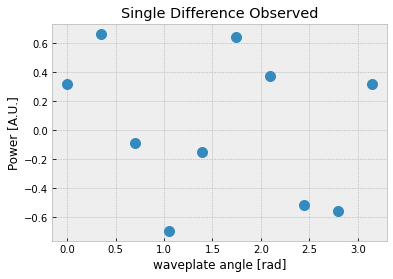

In [4]:
power_o_matrix = np.zeros_like(thetas)
power_e_matrix = np.zeros_like(thetas)
single_diff_matrix = np.zeros_like(thetas)

for i,angle in enumerate(thetas):
    # The polarization state analyzer for both beams of the Wollaston prism
    PSA_o = wollaston(0) @ linear_retarder(angle, np.pi)
    PSA_e = wollaston(1) @ linear_retarder(angle, np.pi)
    power_o_matrix[i] = (PSA_o[0, :] @ S_to_measure)
    power_e_matrix[i] = (PSA_e[0, :] @ S_to_measure)
    single_diff_matrix[i] = power_o_matrix[i] - power_e_matrix[i]

plt.style.use('bmh')
plt.figure()
plt.title('Single Difference Observed')
plt.plot(thetas, single_diff_matrix, marker = 'o', linestyle = 'None', 
    markersize = 10)
plt.xlabel('waveplate angle [rad]')
plt.ylabel('Power [A.U.]')
plt.show()

We can now pass the full list of powers to `dual_channel_polarimeter` instead of a single Stokes vector to perform a real measurement 

In [5]:
S_out = dual_channel_polarimeter(thetas, power_o = power_o_matrix, 
    power_e = power_e_matrix, sub_method = "single_difference", normalized = False)
print('Stokes Vector Measured')
print(S_out)
print('Percent Difference')
print(100 * (S_to_measure[1 : -1] - S_out[1 : -1]) / S_to_measure[1 : -1])

Stokes Vector Measured
[1.         0.32205895 0.6191101  0.        ]
Percent Difference
[2.35802600e-06 1.15021692e-06]


# Double Differencing

Let's do the same with the double difference, where we use $(I_o(\theta_2) - I_e(\theta_2)) - (I_o(\theta_1) - I_e(\theta_1))$ as the observable instead, with $\theta_1$ and $\theta_2$ corresponding to two different HWP angles. 

The double difference power also follows a sinusoid with two frequencies, where:

$$P \propto Q(cos(4\theta_2) - cos(4\theta_1)) + U(sin(4\theta_2) - sin(4\theta_1))$$

Let's test the double difference method with the same randomized normalized input Stokes vector

In [6]:
S_out = dual_channel_polarimeter(thetas, S_in = S_to_measure, 
    sub_method = "double_difference", normalized = False)
print('Stokes Vector Measured')
print(S_out)
print('Percent Difference (Q, U only)')
print(100 * (S_to_measure[1 : -1] - S_out[1 : -1]) / S_to_measure[1 : -1])

Stokes Vector Measured
[1.         0.32205896 0.6191101  0.        ]
Percent Difference (Q, U only)
[-1.59943387e-06  2.25577236e-06]


Great, let's test it with a list of measured powers as well!

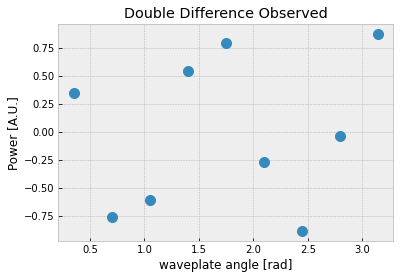

In [7]:
power_o_matrix = np.zeros_like(thetas)
power_e_matrix = np.zeros_like(thetas)
double_diff_matrix = np.zeros_like(thetas[1 : ])

for i , angle in enumerate(thetas):
    # The polarization state analyzer for both beams of the Wollaston prism
    PSA_o = wollaston(0) @ linear_retarder(angle, np.pi)
    PSA_e = wollaston(1) @ linear_retarder(angle, np.pi)
    power_o_matrix[i] = (PSA_o[0, :] @ S_to_measure)
    power_e_matrix[i] = (PSA_e[0, :] @ S_to_measure)
    if i > 0 and i < (len(thetas)):
        double_diff_matrix[i - 1] = (power_o_matrix[i] - power_e_matrix[i]) - \
            (power_o_matrix[i - 1] - power_e_matrix[i - 1])

plt.style.use('bmh')
plt.figure()
plt.title('Double Difference Observed')
plt.plot(thetas[1 :], double_diff_matrix, marker = 'o', linestyle = 'None', 
    markersize = 10)
plt.xlabel('waveplate angle [rad]')
plt.ylabel('Power [A.U.]')
plt.show()

In [8]:
S_out = dual_channel_polarimeter(thetas, power_o = power_o_matrix, 
    power_e = power_e_matrix, sub_method = "double_difference", normalized = False)
print('Stokes Vector Measured')
print(S_out)
print('Percent Difference (Q, U only)')
print(100 * (S_to_measure[1 : -1] - S_out[1 : -1]) / S_to_measure[1 : -1])

Stokes Vector Measured
[1.         0.32205896 0.6191101  0.        ]
Percent Difference
[-1.59943387e-06  2.25577236e-06]
